In [ ]:
# pip install ase dscribe matplotlib seaborn scikit-learn tensorflow
# pip install --upgrade pip
# pip install tensorflow

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dscribe.descriptors import SOAP
from ase.io import read, write
import seaborn as sns
%matplotlib inline

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [14]:
path_to_POSCAR_MBT_unlabelled = 'added_1000_unlabelled_data/'
path_to_POSCAR_MBT_labelled = 'DFT_CONTCARs_MBT/'

In [15]:
def read_POSCAR(file_path):

    poscar_info_list = []
    atomic_species_list = []
    unique_atomic_species_list = set()
    
    for file in os.listdir(file_path):
        if file.endswith('.vasp'):
            poscar_path = os.path.join(file_path, file)
            poscar = read(poscar_path, format = 'vasp')
            poscar_info_list.append(poscar)
            atomic_species_list.append(poscar.get_chemical_symbols())
            for atoms in atomic_species_list:
                unique_atomic_species_list.update(poscar.get_chemical_symbols())
    return poscar_info_list, atomic_species_list, list(unique_atomic_species_list)

In [16]:
poscar_info_list_labelled, atomic_species_list_labelled, unique_atomic_species_list_labelled = read_POSCAR(path_to_POSCAR_MBT_labelled)
poscar_info_list_unlabelled, atomic_species_list_unlabelled, unique_atomic_species_list_unlabelled = read_POSCAR(path_to_POSCAR_MBT_unlabelled)

unique_atomic_species_list = list(set(unique_atomic_species_list_labelled + unique_atomic_species_list_unlabelled))
poscar_info_list = poscar_info_list_labelled + poscar_info_list_unlabelled

In [17]:
def get_SOAP_descriptor(poscar_info_list, r_cut, n_max, l_max):
    
    soap = SOAP(species = unique_atomic_species_list,
               r_cut = r_cut,
               n_max = n_max,
               l_max = l_max,
                sigma = 0.5,    # default: 1.0
                rbf = 'gto',    # deafult: 'gto'
                average='inner',  # default: 'off'
                periodic=True,  # default: False
                sparse=False)    # default: False
    soap_desc = []
    for struct in poscar_info_list:
        soap_struct = soap.create(struct)
        soap_desc.append(soap_struct)
    return np.vstack(soap_desc)

In [18]:
soap_desc = get_SOAP_descriptor(poscar_info_list, 9.0, 6, 5)
soap_desc_labelled = get_SOAP_descriptor(poscar_info_list_labelled, 9.0, 6, 5)

In [19]:
print(soap_desc.shape)
print(soap_desc_labelled.shape)

(1240, 79218)
(240, 79218)


In [20]:
def plot_PCA_variance(soap_desc, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(soap_desc)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('SOAP Descriptors of MBT monolayer')
    plt.grid(True)
    plt.show()

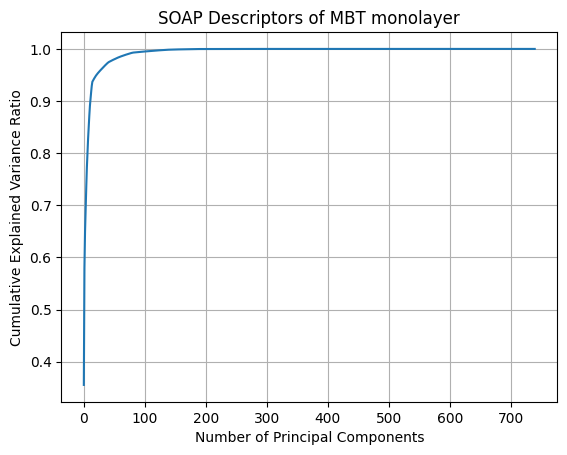

In [21]:
plot_PCA_variance(soap_desc,740)

In [22]:
def perform_pca(soap_desc, optimal_components):
    pca = PCA(n_components=optimal_components)
    soap_pca = pca.fit_transform(soap_desc)
    return soap_pca

In [23]:
optimized_pca = perform_pca(soap_desc,200)
optimized_pca_labelled = perform_pca(soap_desc_labelled,200)

In [24]:
print(optimized_pca.shape)
print(optimized_pca_labelled.shape)

(1240, 200)
(240, 200)


In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(optimized_pca)
X_labelled = scaler.fit_transform(optimized_pca_labelled)

latent_size = 64
input_dim = X.shape[1]

In [26]:
encoder_input = keras.Input(shape=(input_dim,))
encoder_hid_layer_1 = keras.layers.Dense(128, activation = 'selu')(encoder_input)
encoder_hid_layer_2 = keras.layers.Dense(96, activation = 'selu')(encoder_hid_layer_1)
encoder_output = keras.layers.Dense(64, activation = 'selu')(encoder_hid_layer_2)

In [27]:
decoder_hid_layer_1 = keras.layers.Dense(96, activation = 'selu')(encoder_output)
decoder_hid_layer_2 = keras.layers.Dense(128, activation = 'selu')(decoder_hid_layer_1)
decoder_output = keras.layers.Dense(input_dim, activation = 'linear')(decoder_hid_layer_2)

In [28]:
autoencoder = keras.models.Model(inputs = encoder_input, outputs = decoder_output)
autoencoder.compile(optimizer='adam', loss = 'mae',)

In [29]:
hist_autoencoder = autoencoder.fit(X, X, epochs = 500, batch_size = 32, validation_split = 0.2)

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8469 - val_loss: 0.6328
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6468 - val_loss: 0.5949
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6005 - val_loss: 0.5842
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5621 - val_loss: 0.5802
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5507 - val_loss: 0.5781
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5390 - val_loss: 0.5772
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5292 - val_loss: 0.5773
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5136 - val_loss: 0.5764
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5104 - val_loss: 0.5737
Epoch 10/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5072 - val_loss: 0.5738
Epoch 11/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4790 - val_loss: 0.5732
Epoch 12/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3650 - val_loss: 0.5504
Epoch 70/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3537 - val_loss: 0.5498
Epoch 71/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3547 - val_loss: 0.5502
Epoch 72/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3579 - val_loss: 0.5522
Epoch 73/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3504 - val_loss: 0.5498
Epoch 74/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3576 - val_loss: 0.5512
Epoch 75/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3505 - val_loss: 0.5525
Epoch 76/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3493 - val_loss: 0.5507
Epoch 77/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3480 - val_loss: 0.5524
Epoch 78/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3540 - val_loss: 0.5509
Epoch 79/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3482 - val_loss: 0.5505
Epoch 80/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3496 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3164 - val_loss: 0.5527
Epoch 138/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3229 - val_loss: 0.5532
Epoch 139/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3090 - val_loss: 0.5537
Epoch 140/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3089 - val_loss: 0.5530
Epoch 141/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3108 - val_loss: 0.5525
Epoch 142/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3090 - val_loss: 0.5519
Epoch 143/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3128 - val_loss: 0.5529
Epoch 144/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3144 - val_loss: 0.5513
Epoch 145/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3058 - val_loss: 0.5530
Epoch 146/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3121 - val_loss: 0.5522
Epoch 147/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3041 - val_loss: 0.5527
Epoch 148/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2912 - val_loss: 0.5501
Epoch 205/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2884 - val_loss: 0.5491
Epoch 206/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2909 - val_loss: 0.5500
Epoch 207/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2873 - val_loss: 0.5506
Epoch 208/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2926 - val_loss: 0.5493
Epoch 209/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2930 - val_loss: 0.5500
Epoch 210/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2978 - val_loss: 0.5500
Epoch 211/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2839 - val_loss: 0.5497
Epoch 212/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2905 - val_loss: 0.5515
Epoch 213/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2864 - val_loss: 0.5494
Epoch 214/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2876 - val_loss: 0.5493
Epoch 215/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2862 - val_loss: 0.5488
Epoch 272/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2813 - val_loss: 0.5490
Epoch 273/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2799 - val_loss: 0.5490
Epoch 274/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2773 - val_loss: 0.5500
Epoch 275/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2730 - val_loss: 0.5493
Epoch 276/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2789 - val_loss: 0.5491
Epoch 277/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2760 - val_loss: 0.5489
Epoch 278/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2746 - val_loss: 0.5500
Epoch 279/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2759 - val_loss: 0.5486
Epoch 280/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2783 - val_loss: 0.5486
Epoch 281/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2778 - val_loss: 0.5485
Epoch 282/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2710 - val_loss: 0.5509
Epoch 339/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - val_loss: 0.5503
Epoch 340/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2654 - val_loss: 0.5516
Epoch 341/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2696 - val_loss: 0.5517
Epoch 342/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2737 - val_loss: 0.5503
Epoch 343/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2751 - val_loss: 0.5503
Epoch 344/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2663 - val_loss: 0.5518
Epoch 345/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2674 - val_loss: 0.5510
Epoch 346/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2661 - val_loss: 0.5502
Epoch 347/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2591 - val_loss: 0.5507
Epoch 348/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2682 - val_loss: 0.5512
Epoch 349/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2532 - val_loss: 0.5528
Epoch 406/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2646 - val_loss: 0.5519
Epoch 407/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2593 - val_loss: 0.5521
Epoch 408/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2621 - val_loss: 0.5529
Epoch 409/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2562 - val_loss: 0.5535
Epoch 410/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2604 - val_loss: 0.5535
Epoch 411/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2624 - val_loss: 0.5532
Epoch 412/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2606 - val_loss: 0.5533
Epoch 413/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2604 - val_loss: 0.5528
Epoch 414/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2582 - val_loss: 0.5531
Epoch 415/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2557 - val_loss: 0.5529
Epoch 416/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2549 - val_loss: 0.5537
Epoch 473/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2583 - val_loss: 0.5536
Epoch 474/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2480 - val_loss: 0.5541
Epoch 475/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2513 - val_loss: 0.5541
Epoch 476/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2547 - val_loss: 0.5547
Epoch 477/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2540 - val_loss: 0.5546
Epoch 478/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2540 - val_loss: 0.5541
Epoch 479/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2527 - val_loss: 0.5537
Epoch 480/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2498 - val_loss: 0.5548
Epoch 481/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2487 - val_loss: 0.5541
Epoch 482/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2527 - val_loss: 0.5542
Epoch 483/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

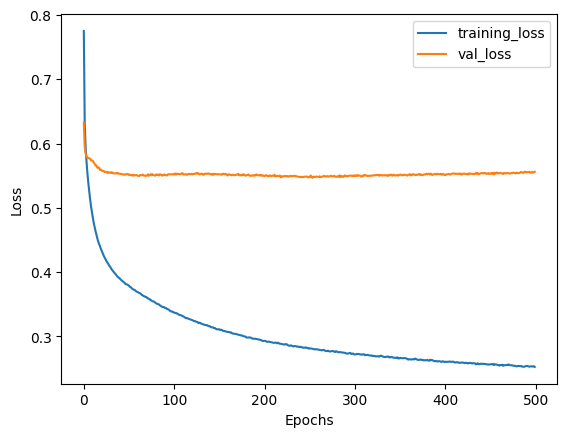

In [30]:
plt.plot(hist_autoencoder.history['loss'], label='training_loss')
plt.plot(hist_autoencoder.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [31]:
reconstructed_X = autoencoder.predict(X)
reconstructed_X_labelled = autoencoder.predict(X_labelled)

encoder = keras.models.Model(inputs = encoder_input, outputs = encoder_output)

compressed_X = encoder.predict(X)
compressed_X_labelled = encoder.predict(X_labelled)

print(compressed_X.shape)
print(compressed_X_labelled.shape)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(1240, 64)
(240, 64)


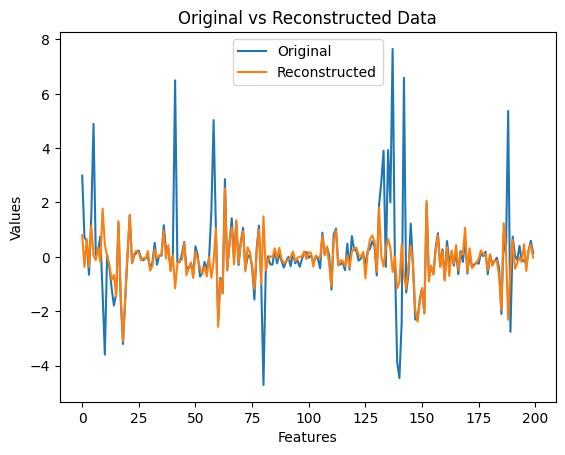

In [32]:
sample_idx = X[0]
plt.plot(X[0], label='Original')
plt.plot(reconstructed_X[0], label='Reconstructed')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Original vs Reconstructed Data')
plt.legend()
plt.show()

In [33]:
## FFNN

In [34]:
monolayer_MBT_DFT_data = pd.read_csv('id_props_240_labelled_data_MBT.csv')

In [35]:
y = monolayer_MBT_DFT_data[['Ef_per_cell','Mu_per_cell','Eg']]

In [36]:
ffnn_MBT = keras.models.Sequential([
    keras.layers.Dense(32, activation = 'selu', input_dim = latent_size),
    keras.layers.Dense(16, activation = 'selu'),
    keras.layers.Dense(8, activation = 'selu'),
    keras.layers.Dense(3, activation = 'linear')
])

C:\Users\Romakanta\Desktop\vENVs\vSOAP\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(compressed_X_labelled, y, test_size = 0.2, random_state = 1)

In [38]:
ffnn_MBT.compile(optimizer = 'adam', loss = 'mae')
hist_ffnn_MBT = ffnn_MBT.fit(X_train, y_train, epochs = 500, batch_size = 32, validation_split = 0.2)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.0688 - val_loss: 1.8272
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6859 - val_loss: 1.6305
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4142 - val_loss: 1.4869
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2493 - val_loss: 1.3742
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1291 - val_loss: 1.2891
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0781 - val_loss: 1.2218
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9726 - val_loss: 1.1693
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8970 - val_loss: 1.1223
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8095 - val_loss: 1.0887
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7926 - val_loss: 1.0619
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6942 - val_loss: 1.0453
Epoch 12/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6605 - val_loss: 1.0233

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1361 - val_loss: 0.8759
Epoch 71/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1546 - val_loss: 0.8758
Epoch 72/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1374 - val_loss: 0.8735
Epoch 73/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1355 - val_loss: 0.8711
Epoch 74/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1623 - val_loss: 0.8747
Epoch 75/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1570 - val_loss: 0.8851
Epoch 76/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1443 - val_loss: 0.8763
Epoch 77/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1426 - val_loss: 0.8794
Epoch 78/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1452 - val_loss: 0.8811
Epoch 79/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1462 - val_loss: 0.8742
Epoch 80/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1357 - val_loss: 0.8803
Epoch 81/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1436 - val_loss: 0.8752
Epoch

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0551 - val_loss: 0.9094
Epoch 140/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0582 - val_loss: 0.8990
Epoch 141/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0624 - val_loss: 0.9046
Epoch 142/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0630 - val_loss: 0.9011
Epoch 143/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0646 - val_loss: 0.9029
Epoch 144/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0641 - val_loss: 0.9041
Epoch 145/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0666 - val_loss: 0.9047
Epoch 146/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0678 - val_loss: 0.8989
Epoch 147/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0598 - val_loss: 0.9057
Epoch 148/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0596 - val_loss: 0.9075
Epoch 149/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0568 - val_loss: 0.9055
Epoch 150/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0553 - val_loss: 0

Epoch 208/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0424 - val_loss: 0.9002
Epoch 209/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0401 - val_loss: 0.8978
Epoch 210/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0436 - val_loss: 0.9049
Epoch 211/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0433 - val_loss: 0.9078
Epoch 212/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0382 - val_loss: 0.8972
Epoch 213/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0459 - val_loss: 0.8983
Epoch 214/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0405 - val_loss: 0.9020
Epoch 215/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0498 - val_loss: 0.9009
Epoch 216/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0396 - val_loss: 0.8956
Epoch 217/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0478 - val_loss: 0.9021
Epoch 218/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0426 - val_loss: 0.8971
Epoch 219/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0442

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0307 - val_loss: 0.8933
Epoch 277/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0351 - val_loss: 0.9009
Epoch 278/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0358 - val_loss: 0.8939
Epoch 279/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0379 - val_loss: 0.8905
Epoch 280/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0355 - val_loss: 0.8924
Epoch 281/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0358 - val_loss: 0.8928
Epoch 282/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0308 - val_loss: 0.8950
Epoch 283/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0332 - val_loss: 0.8968
Epoch 284/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0323 - val_loss: 0.8914
Epoch 285/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0334 - val_loss: 0.8917
Epoch 286/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0325 - val_loss: 0.8965
Epoch 287/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0340 - val_loss: 

Epoch 345/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0290 - val_loss: 0.8863
Epoch 346/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0276 - val_loss: 0.8897
Epoch 347/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0262 - val_loss: 0.8904
Epoch 348/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296 - val_loss: 0.8847
Epoch 349/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0305 - val_loss: 0.8852
Epoch 350/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0321 - val_loss: 0.9004
Epoch 351/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0322 - val_loss: 0.8902
Epoch 352/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0332 - val_loss: 0.8904
Epoch 353/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0346 - val_loss: 0.8884
Epoch 354/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0368 - val_loss: 0.8845
Epoch 355/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0306 - val_loss: 0.8871
Epoch 356/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.029

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0272 - val_loss: 0.8841
Epoch 414/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0274 - val_loss: 0.8866
Epoch 415/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0268 - val_loss: 0.8937
Epoch 416/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0266 - val_loss: 0.8893
Epoch 417/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0312 - val_loss: 0.8847
Epoch 418/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0230 - val_loss: 0.8859
Epoch 419/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0199 - val_loss: 0.8906
Epoch 420/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0223 - val_loss: 0.8921
Epoch 421/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0259 - val_loss: 0.8864
Epoch 422/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0308 - val_loss: 0.8892
Epoch 423/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0312 - val_loss: 0.8883
Epoch 424/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0272 - val_loss: 

Epoch 482/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0242 - val_loss: 0.8917
Epoch 483/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0269 - val_loss: 0.8895
Epoch 484/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0291 - val_loss: 0.8869
Epoch 485/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0324 - val_loss: 0.8845
Epoch 486/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0314 - val_loss: 0.8910
Epoch 487/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0350 - val_loss: 0.8867
Epoch 488/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0336 - val_loss: 0.8840
Epoch 489/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0274 - val_loss: 0.8856
Epoch 490/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0249 - val_loss: 0.8882
Epoch 491/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0228 - val_loss: 0.8798
Epoch 492/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0279 - val_loss: 0.8835
Epoch 493/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0249

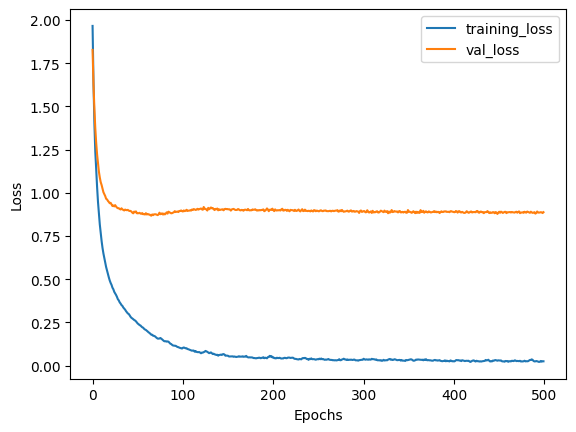

In [39]:
plt.plot(hist_ffnn_MBT.history['loss'], label='training_loss')
plt.plot(hist_ffnn_MBT.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [40]:
pred_train = ffnn_MBT.predict(X_train)
pred_test = ffnn_MBT.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


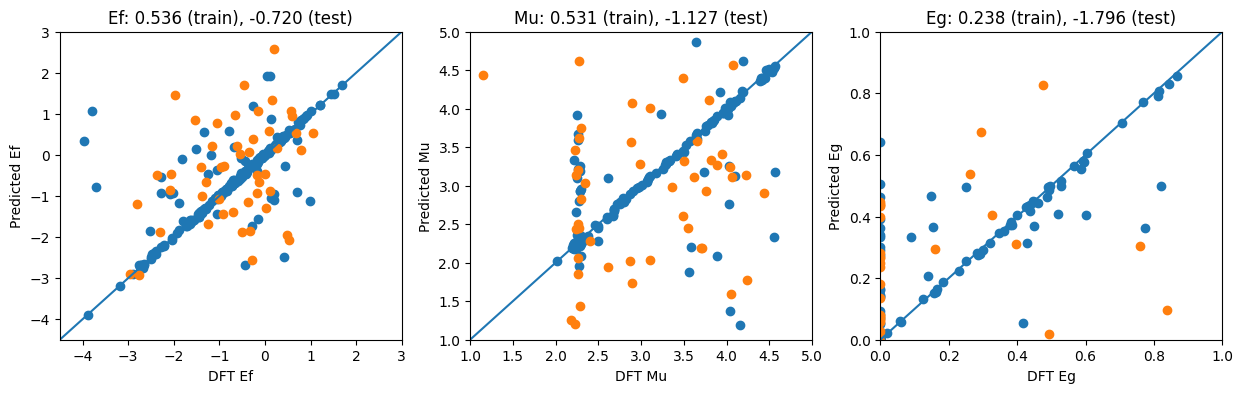

In [41]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (15,4))
ax1.scatter(y_train['Ef_per_cell'], pred_train[:,0])
ax1.scatter(y_test['Ef_per_cell'], pred_test[:,0])
ax1.plot([-4.5, 3], [-4.5, 3])

ax2.scatter(y_train['Mu_per_cell'], pred_train[:,1])
ax2.scatter(y_test['Mu_per_cell'], pred_test[:,1])
ax2.plot([0, 5], [0, 5])

ax3.scatter(y_train['Eg'], pred_train[:,2])
ax3.scatter(y_test['Eg'], pred_test[:,2])
ax3.plot([0, 1], [0, 1])

ax1.set_title('Ef: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Ef_per_cell'], pred_train[:,0]),metrics.r2_score(y_test['Ef_per_cell'], pred_test[:,0])))
ax2.set_title('Mu: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Mu_per_cell'], pred_train[:,1]),metrics.r2_score(y_test['Mu_per_cell'], pred_test[:,1])))
ax3.set_title('Eg: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Eg'], pred_train[:,2]),metrics.r2_score(y_test['Eg'], pred_test[:,2])))

ax1.set_xlabel('DFT Ef')
ax1.set_ylabel('Predicted Ef')

ax2.set_xlabel('DFT Mu')
ax2.set_ylabel('Predicted Mu')

ax3.set_xlabel('DFT Eg')
ax3.set_ylabel('Predicted Eg')

ax1.set_xlim([-4.5, 3])
ax1.set_ylim([-4.5, 3])

ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

plt.show()

In [ ]:
print(metrics.r2_score(y_train['Ef_per_cell'], pred_train[:,0]))
print(metrics.r2_score(y_train['Mu_per_cell'], pred_train[:,1]))
print(metrics.r2_score(y_train['Eg'], pred_train[:,2]))

In [ ]:
print(metrics.mean_absolute_error(y_train['Ef_per_cell'], pred_train[:,0]))
print(metrics.mean_absolute_error(y_train['Mu_per_cell'], pred_train[:,1]))
print(metrics.mean_absolute_error(y_train['Eg'], pred_train[:,2]))

In [ ]:
print(metrics.r2_score(y_test['Ef_per_cell'], pred_test[:,0]))
print(metrics.r2_score(y_test['Mu_per_cell'], pred_test[:,1]))
print(metrics.r2_score(y_test['Eg'], pred_test[:,2]))

In [ ]:
print(metrics.mean_absolute_error(y_test['Ef_per_cell'], pred_test[:,0]))
print(metrics.mean_absolute_error(y_test['Mu_per_cell'], pred_test[:,1]))
print(metrics.mean_absolute_error(y_test['Eg'], pred_test[:,2]))